In [87]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import pandas as pd

X_test = pd.read_parquet('../data/X_test.parquet')
y_test = pd.read_parquet('../data/y_test.parquet')

# 1. Charger le modèle
model = lgb.Booster(model_file='../src/scoring_model.txt')


# Test de sensibilité
client_pauvre = [5000, 100000, 30.0, 0, 5, 0, 1]   # Petit revenu, gros endettement
client_riche  = [5000, 100000, 30.0, 2, 5, 0, 1]   # Gros revenu, faible endettement

prob_pauvre = model.predict(np.array(client_pauvre).reshape(1, -1))[0]
prob_riche = model.predict(np.array(client_riche).reshape(1, -1))[0]

print(f"Probabilité Défaut (Pauvre): {prob_pauvre:.4f}")
print(f"Probabilité Défaut (Riche) : {prob_riche:.4f}")

Probabilité Défaut (Pauvre): 0.5818
Probabilité Défaut (Riche) : 0.4781


In [85]:
y_test['target'].unique()

array([0, 1])

In [88]:
# 1. Prédiction sur le set de test
y_pred_proba = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"L'AUC du modèle est de : {auc_score:.4f}")

L'AUC du modèle est de : 0.6387


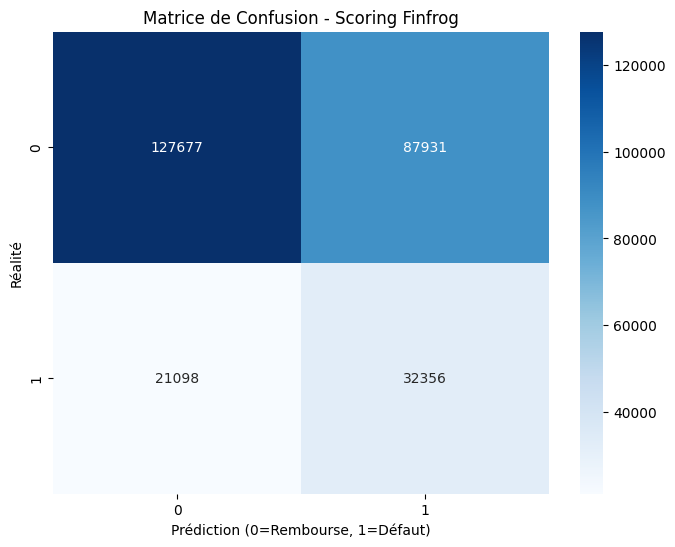

In [89]:
# 2. Matrice de confusion (Seuil par défaut 0.5)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred_proba]
cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédiction (0=Rembourse, 1=Défaut)')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion - Scoring Finfrog')
plt.show()

In [40]:
cols = pd.read_csv('../data/accepted_2007_to_2018Q4.csv', nrows=0).columns.tolist()
print(f"Colonnes disponibles : {cols}")

Colonnes disponibles : ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_jo

In [91]:
features = ['grade']
df = pd.read_csv('../data/accepted_2007_to_2018Q4.csv', usecols=features)
df['grade'].unique()

array(['C', 'B', 'F', 'A', 'E', 'D', 'G', nan], dtype=object)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

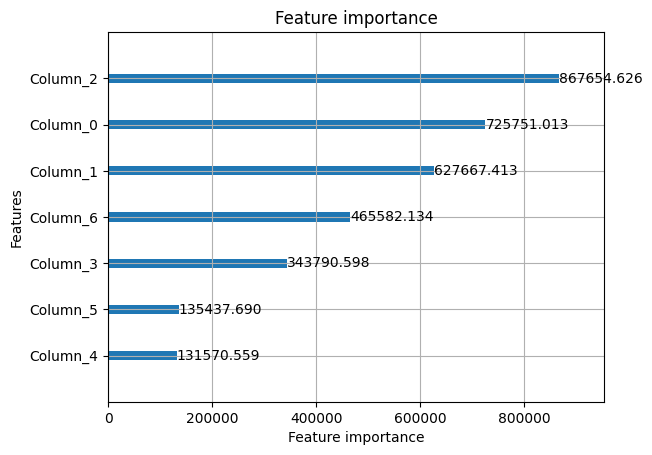

In [ ]:
import lightgbm as lgb
lgb.plot_importance(model, importance_type='gain')
features = ['loan_amnt', 'annual_inc', 'dti', 'home_ownership', 'open_acc','emp_length','verification_status']

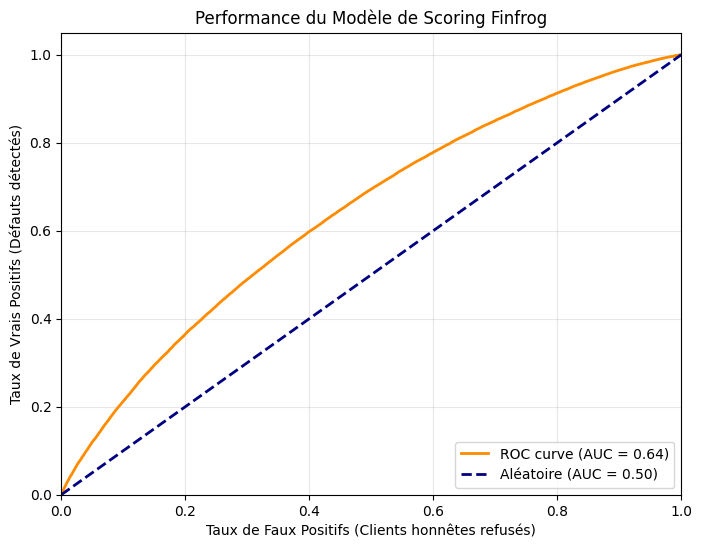

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1. Obtenir les probabilités de défaut sur le jeu de test
# bst est ton modèle LightGBM chargé
y_pred_prob = model.predict(X_test)

# 2. Calculer les points de la courbe
# fpr = False Positive Rate, tpr = True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Affichage du graphique
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (Clients honnêtes refusés)')
plt.ylabel('Taux de Vrais Positifs (Défauts détectés)')
plt.title('Performance du Modèle de Scoring Finfrog')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()